# Evolution strategy agent in Python

### Importing packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from pandas_datareader import data

In [2]:
df_full = pd.read_csv("df.csv")

In [23]:
df_full = panel_data = data.DataReader('INPX', 'yahoo', "2016-01-01")
df_full1 = panel_data = data.DataReader('MSFT', 'yahoo', "2016-01-01")
df_full2 = panel_data = data.DataReader('AAPL', 'yahoo', "2016-01-01")
df_full3 = panel_data = data.DataReader('GLPG', 'yahoo', "2016-01-01")
df_full4 = panel_data = data.DataReader('QURE', 'yahoo', "2016-01-01")
df_full5 = panel_data = data.DataReader('^GSPC', 'yahoo', "2016-01-01")


### Implementing the strategy


In [9]:
df = df_full.copy()

In [67]:
class Evolution_Strategy:
    inputs = []

    def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(0.3 + 1.5*np.random.randn(*w.shape))
                population.append(x)
                
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)

            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (w + self.learning_rate/(self.population_size*self.sigma)*np.dot(A.T, rewards).T)

            if (i+1)%print_every == 0:
                print('Iteration %d. Reward %f'%(i+1, self.reward_function(self.weights)))

        print('Time taken:', time.time()-lasttime, 'seconds.')

In [68]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [np.random.randn(input_size, layer_size), np.random.randn(layer_size, output_size), np.random.randn(1, layer_size)]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights
    
    def set_weights(set, weights):
        self.weights = weights

In [69]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03


    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Evolution_Strategy(self.model.get_weights(), self.get_reward, self.POPULATION_SIZE, self.SIGMA, self.LEARNING_RATE)


    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    


    
    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = (initial_money - starting_money)/starting_money * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [80]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)

Iteration 10. Reward -98.769000
Iteration 20. Reward -99.027699
Iteration 30. Reward -99.033900
Iteration 40. Reward -10.187800
Iteration 50. Reward 2.986200
Iteration 60. Reward 4.405900
Iteration 70. Reward 6.905800
Iteration 80. Reward 31.693500
Iteration 90. Reward 55.963501
Iteration 100. Reward 52.117801
Iteration 110. Reward 74.509901
Iteration 120. Reward 53.290900
Iteration 130. Reward 82.063000
Iteration 140. Reward 94.117600
Iteration 150. Reward 96.068000
Iteration 160. Reward 115.196999
Iteration 170. Reward 119.779000
Iteration 180. Reward 121.015701
Iteration 190. Reward 119.802300
Iteration 200. Reward 118.392800
Iteration 210. Reward 127.367599
Iteration 220. Reward 127.879900
Iteration 230. Reward 119.832999
Iteration 240. Reward 127.149500
Iteration 250. Reward 118.702900
Iteration 260. Reward 110.670500
Iteration 270. Reward 113.978700
Iteration 280. Reward 128.330900
Iteration 290. Reward 129.555801
Iteration 300. Reward 123.138600
Iteration 310. Reward 121.408300


In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy()

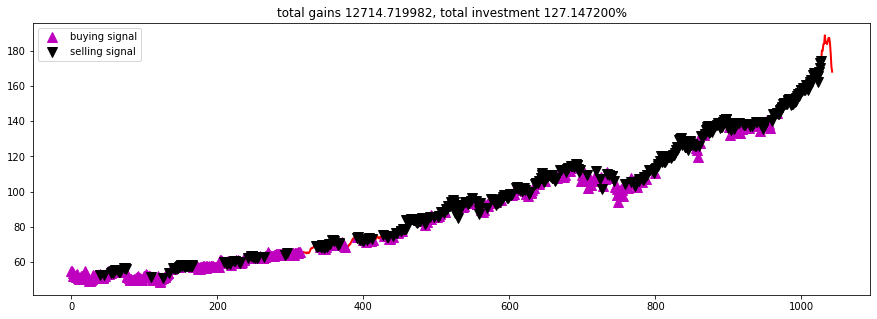

In [82]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

# Deep Evolution Strategies

In [22]:
name = 'Deep Evolution Strategy'

In [3]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[: t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [4]:
class Deep_Evolution_Strategy:
    
    def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
                
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)

            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (w + self.learning_rate/(self.population_size*self.sigma)*np.dot(A.T, rewards).T)

            if (i+1)%print_every == 0:
                print('Iteration %d. Reward %f'%(i+1, self.reward_function(self.weights)))

        print('Time taken:', time.time()-lasttime, 'seconds.')

In [5]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [np.random.randn(input_size, layer_size), 
                        np.random.randn(layer_size, output_size), 
                        np.random.randn(layer_size, 1), 
                        np.random.randn(1, layer_size)]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights
    
    def set_weights(set, weights):
        self.weights = weights

In [6]:
window_size = 30
model = Model(window_size, 500, 3)

In [29]:
df = df_full2

close = df.Close.values.tolist()
get_state(close, 0, 10)

initial_money = 10000
starting_money = initial_money
len_close = len(close) - 1
weight = model
skip = 1

state = get_state(close, 0, window_size + 1)
inventory = []
quantity = 0

max_buy = 5
max_sell = 5


def act(model, sequence):
    decision, buy = model.predict(np.array(sequence))
    return np.argmax(decision[0]), int(buy[0])


for t in range(0, len_close, skip):
    action, buy = act(weight, state)
    next_state = get_state(close, t + 1, window_size + 1)
    if action == 1 and initial_money >= close[t]:
        if buy < 0:
            buy = 1
        if buy > max_buy:
            buy_units = max_buy
        else:
            buy_units = buy
        total_buy = buy_units * close[t]
        initial_money -= total_buy
        inventory.append(total_buy)
        quantity += buy_units
    elif action == 2 and len(inventory) > 0:
        if quantity > max_sell:
            sell_units = max_sell
        else:
            sell_units = quantity
        quantity -= sell_units
        total_sell = sell_units * close[t]
        initial_money += total_sell

    state = next_state
((initial_money - starting_money) / starting_money) * 100

84.62021110534667

In [30]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(
        self, model, money, max_buy, max_sell, close, window_size, skip
    ):
        self.window_size = window_size
        self.skip = skip
        self.close = close
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        len_close = len(self.close) - 1

        self.model.weights = weights
        state = get_state(self.close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        len_close = len(self.close) - 1
        state = get_state(self.close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.max_buy*self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print('\ntotal gained %f, total investment %f %%'% (initial_money - starting_money, invest))
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(close, 'X', label = 'predict buy', markevery = states_buy, c = 'b')
        plt.plot(close, 'o', label = 'predict sell', markevery = states_sell, c = 'r')
        plt.legend()
        plt.show()

In [31]:
model = Model(input_size = window_size, layer_size = 1000, output_size = 3)
agent = Agent(
    model = model,
    money = 10000,
    max_buy = 5,
    max_sell = 5,
    close = close,
    window_size = window_size,
    skip = 1,
)

In [ ]:
agent.fit(iterations = 500, checkpoint = 10)

Iteration 10. Reward 40.623509
Iteration 20. Reward 44.285806
Iteration 30. Reward 77.998500
Iteration 40. Reward 113.988098
Iteration 50. Reward 204.454802
Iteration 60. Reward 224.757907
Iteration 70. Reward 268.685311
Iteration 80. Reward 277.183707
Iteration 90. Reward 270.383603
Iteration 100. Reward 285.730703
Iteration 110. Reward 290.697604
Iteration 120. Reward 287.963603
Iteration 130. Reward 304.094508
Iteration 140. Reward 288.126910
Iteration 150. Reward 305.081311
Iteration 160. Reward 305.645913
Iteration 170. Reward 302.596212
Iteration 180. Reward 286.912712
Iteration 190. Reward 294.664612
Iteration 200. Reward 269.325207
Iteration 210. Reward 282.607210
Iteration 220. Reward 272.121414
Iteration 230. Reward 302.971209
Iteration 240. Reward 298.223308
Iteration 250. Reward 311.021410
Iteration 260. Reward 321.637106
Iteration 270. Reward 328.050808
Iteration 280. Reward 331.314406
Iteration 290. Reward 330.659706
Iteration 300. Reward 336.208409
Iteration 310. Reward 

In [ ]:
agent.buy()